In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
import pandas as pd

In [2]:
def log_results(results, filename, type_):
    # Define the headers for your CSV file

    if type_ == '1k_logs':
        headers = ['Mean Episodic Reward', 'Critic loss', 'Actor loss']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)

    elif type_ == '20k_ep_rewards':
        headers = ['Mean episodic reward']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)
    
    elif type_ == 'ep_reward':
        headers = ['Episodic reward', 'Step']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)


In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions),
            nn.Softmax()
        )

    def forward(self, x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Actor_continuous(nn.Module):

    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.Tensor(x)
        mean = self.model(x)
        log_std = self.log_std

        return mean, log_std

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [6]:
class A2C_Agent(): #this should work with more parallel environment already, not the evaluate functions

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic, continuous = False):
        self.n_envs = n_envs
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
        self.continuous = continuous
    

    def choose_action(self, states, action_type = "training"):          

        if not self.continuous : 
            if action_type == "training":
                state_values = self.critic(states)
                action_probs = self.actor(states)
                actions_pd = torch.distributions.Categorical(probs=action_probs)
                actions = actions_pd.sample()
                actions_log_prog = actions_pd.log_prob(actions)
                return actions, actions_log_prog, state_values
            
            elif action_type == 'eval':
                with torch.no_grad()  :    
                    state_values = self.critic(states)
                    action_probs = self.actor(states)
                    actions = torch.argmax(action_probs) #greedy policy
                return actions, state_values
        
        else :
            if action_type == 'training':
                state_values = self.critic(states)
                mean, log_std = self.actor(states)
                normal = torch.distributions.Normal(mean, torch.exp(log_std))
                actions = normal.sample()
                actions_log_prob = normal.log_prob(actions)
                actions_r = torch.clamp(actions, -3., 3.)
                return actions_r, actions_log_prob, state_values
            
            elif action_type == 'eval':
                with torch.no_grad():
                    state_values = self.critic(states)
                    mean, log_std = self.actor(states)
                    normal = torch.distributions.Normal(mean, torch.exp(log_std))
                    actions = normal.sample()
                    actions_r = torch.clamp(actions, -3., 3.)
                return actions_r, state_values
        

        
    
    def get_losses(self, rewards, v_states, v_next_states, log_probs, gamma, terminated):

        if terminated is not None:
        
            delta = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * (v_next_states).detach()
            advantage = delta - v_states
            critic_loss = advantage.pow(2).mean()
            actor_loss = - (advantage.detach() * log_probs.reshape_as(advantage.detach())).mean()

            return actor_loss, critic_loss
        
        else:
            advantages = v_next_states.detach() - v_states

            critic_loss = (advantages.pow(2)).mean()
            actor_loss = (-(advantages.detach() * log_probs)).mean()

            return actor_loss, critic_loss
            
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self):
        
        episodic_rewards_10 = []
        v_values = []
        env = gym.make("InvertedPendulum-v4")
        for j in range(10):
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "eval") 
                #get the current value function fro one trajectory (j==0)
                if j == 0 : v_values.append(state_values.detach().data.numpy()) #shitty with float
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10))
        return np.mean(episodic_rewards_10), v_values
    
    def evaluate_training(self, total_rewards, actor_loss, critic_loss, filename, type_):

        avg_reward = 0

        for v in total_rewards:
            avg_reward += np.mean(v)
        
        avg_reward /= len(total_rewards)

        log_results([avg_reward, critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filename, type_)
    

In [7]:
def train(seed, filenames, n_envs=1, sparse=False):
    v_values = []
    max_steps = 500000

    env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
    state_dim  = env.single_observation_space.shape[0]
    # n_actions = env.single_action_space.n

    torch.manual_seed(seed)
    actor = Actor_continuous(state_dim)
    critic = Critic(state_dim)
    agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=1e-5, lr_critic=1e-3, continuous=True)
    
    state = env.reset(seed=seed)[0]

    total_rewards = [[] for _ in range(n_envs)]
    ep_reward = [0]*n_envs

    for s in tqdm(range(0, max_steps, n_envs)):

        ## We don't need to reset the environment since we use gym's AsyncEnv ##
        
        actions, actions_log_prog, v_state = agent.choose_action(state)
        
        next_state, reward, terminated, truncated, info = env.step(actions.numpy())
        st1 = next_state.copy()

        for i in range(n_envs):
            ep_reward[i] += reward[i]
            if terminated[i] or truncated[i]:
                total_rewards[i].append(ep_reward[i])
                st1[i] = info['final_observation'][i]
                log_results([ep_reward[i], s], filenames[3], 'ep_reward')
                ep_reward[i] = 0
        
        if sparse:
            reward = np.where(reward == 1.0, np.random.binomial(1, 0.1, size=reward.shape), reward)

        v_st1 = agent.critic(st1)
            
        actor_loss, critic_loss = agent.get_losses(reward, v_state, v_st1, actions_log_prog, 0.99, terminated)
        state = next_state


        agent.update_params(critic_loss, actor_loss)
        
        if (s % (round(1000/(n_envs))*n_envs)) == 0:
            agent.evaluate_training(total_rewards, actor_loss, critic_loss, filenames[0], "1k_logs")
            total_rewards = [[] for _ in range(n_envs)]
        if (s % (round(20000/(n_envs))*n_envs) == 0): 
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)]
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)



In [8]:
seeds = [52, 123, 21]
for seed in seeds:
    folder_name = 'Results_1env_1nstep_continuous'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 17/500000 [00:00<1:32:23, 90.20it/s]

episodic return of the 20000: 6.4


  4%|▍         | 20042/500000 [02:02<50:20, 158.89it/s]  

episodic return of the 20000: 37.2


  8%|▊         | 40030/500000 [03:58<1:38:58, 77.46it/s] 

episodic return of the 20000: 60.2


 12%|█▏        | 60032/500000 [05:38<2:35:10, 47.25it/s] 

episodic return of the 20000: 86.1


 16%|█▌        | 80017/500000 [07:38<1:45:25, 66.40it/s] 

episodic return of the 20000: 98.8


 20%|██        | 100038/500000 [09:44<1:13:22, 90.84it/s]

episodic return of the 20000: 115.3


 24%|██▍       | 120020/500000 [11:57<2:05:37, 50.42it/s] 

episodic return of the 20000: 146.4


 28%|██▊       | 140026/500000 [14:10<4:12:04, 23.80it/s] 

episodic return of the 20000: 300.3


 32%|███▏      | 160032/500000 [16:37<5:56:47, 15.88it/s]

episodic return of the 20000: 685.9


 36%|███▌      | 180019/500000 [19:21<11:28:53,  7.74it/s]

episodic return of the 20000: 844.1


 40%|████      | 200015/500000 [21:51<5:07:29, 16.26it/s] 

episodic return of the 20000: 318.2


 44%|████▍     | 220032/500000 [24:20<5:52:57, 13.22it/s]

episodic return of the 20000: 806.8


 48%|████▊     | 240020/500000 [26:35<3:50:17, 18.82it/s]

episodic return of the 20000: 743.0


 52%|█████▏    | 260035/500000 [28:43<4:09:29, 16.03it/s]

episodic return of the 20000: 884.0


 56%|█████▌    | 280040/500000 [30:39<1:47:43, 34.03it/s]

episodic return of the 20000: 651.3


 60%|██████    | 300039/500000 [32:13<1:59:01, 28.00it/s]

episodic return of the 20000: 610.8


 64%|██████▍   | 320028/500000 [33:45<2:05:12, 23.96it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340019/500000 [35:26<7:15:53,  6.12it/s] 

episodic return of the 20000: 792.9


 72%|███████▏  | 360022/500000 [37:46<3:30:43, 11.07it/s]

episodic return of the 20000: 999.4


 76%|███████▌  | 380022/500000 [39:34<1:26:48, 23.03it/s]

episodic return of the 20000: 850.8


 80%|████████  | 400013/500000 [41:26<3:36:56,  7.68it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 420034/500000 [43:14<1:10:42, 18.85it/s]

episodic return of the 20000: 996.1


 88%|████████▊ | 440023/500000 [45:01<1:00:47, 16.44it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 460027/500000 [46:50<38:03, 17.51it/s]  

episodic return of the 20000: 1000.0


 96%|█████████▌| 480028/500000 [48:44<24:24, 13.64it/s] 

episodic return of the 20000: 757.1


  0%|          | 13/500000 [00:00<2:59:24, 46.45it/s]

episodic return of the 20000: 9.1


  4%|▍         | 20021/500000 [02:49<1:11:15, 112.25it/s]

episodic return of the 20000: 33.9


  8%|▊         | 40022/500000 [04:54<1:20:57, 94.69it/s] 

episodic return of the 20000: 79.4


 12%|█▏        | 60035/500000 [06:57<1:31:01, 80.56it/s] 

episodic return of the 20000: 87.8


 16%|█▌        | 80018/500000 [09:06<1:51:09, 62.97it/s] 

episodic return of the 20000: 142.4


 20%|██        | 100033/500000 [11:00<1:38:42, 67.53it/s]

episodic return of the 20000: 133.7


 24%|██▍       | 120030/500000 [13:06<2:37:54, 40.10it/s] 

episodic return of the 20000: 248.9


 28%|██▊       | 140027/500000 [15:18<6:13:08, 16.08it/s] 

episodic return of the 20000: 725.3


 32%|███▏      | 160020/500000 [17:34<7:47:01, 12.13it/s] 

episodic return of the 20000: 908.1


 36%|███▌      | 180050/500000 [24:44<2:00:22, 44.30it/s]  

episodic return of the 20000: 802.9


 40%|████      | 200038/500000 [34:14<1:46:27, 46.96it/s] 

episodic return of the 20000: 944.1


 44%|████▍     | 220030/500000 [45:56<71:09:23,  1.09it/s]

episodic return of the 20000: 864.4


 48%|████▊     | 240057/500000 [53:51<1:02:51, 68.92it/s]  

episodic return of the 20000: 600.2


 52%|█████▏    | 260034/500000 [58:05<3:34:05, 18.68it/s]  

episodic return of the 20000: 995.9


 56%|█████▌    | 280031/500000 [59:30<2:42:12, 22.60it/s]

episodic return of the 20000: 854.0


 60%|██████    | 300037/500000 [1:00:58<1:34:45, 35.17it/s]

episodic return of the 20000: 988.7


 64%|██████▍   | 320055/500000 [1:02:23<1:34:52, 31.61it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340019/500000 [1:03:47<2:40:18, 16.63it/s]

episodic return of the 20000: 921.9


 72%|███████▏  | 360026/500000 [1:05:06<1:40:23, 23.24it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380043/500000 [1:06:36<1:24:34, 23.64it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400036/500000 [1:07:58<36:31, 45.61it/s]  

episodic return of the 20000: 809.6


 84%|████████▍ | 420024/500000 [1:09:19<59:56, 22.24it/s] 

episodic return of the 20000: 1000.0


 88%|████████▊ | 440054/500000 [1:10:35<30:12, 33.08it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460056/500000 [1:11:48<16:12, 41.06it/s] 

episodic return of the 20000: 772.8


 96%|█████████▌| 480059/500000 [1:13:01<09:16, 35.83it/s] 

episodic return of the 20000: 966.9


  0%|          | 47/500000 [00:00<35:27, 234.96it/s]

episodic return of the 20000: 7.0


  4%|▍         | 20033/500000 [01:10<41:33, 192.45it/s]  

episodic return of the 20000: 63.5


  8%|▊         | 40047/500000 [02:18<49:27, 155.01it/s]  

episodic return of the 20000: 148.7


 12%|█▏        | 60049/500000 [03:27<50:58, 143.86it/s]  

episodic return of the 20000: 150.4


 16%|█▌        | 80032/500000 [04:36<45:23, 154.19it/s]  

episodic return of the 20000: 151.4


 20%|██        | 100032/500000 [05:46<1:14:35, 89.36it/s]

episodic return of the 20000: 350.2


 24%|██▍       | 120037/500000 [06:58<1:57:23, 53.95it/s] 

episodic return of the 20000: 607.2


 28%|██▊       | 140043/500000 [08:10<2:32:52, 39.24it/s]

episodic return of the 20000: 861.8


 32%|███▏      | 160033/500000 [09:20<1:30:38, 62.51it/s]

episodic return of the 20000: 394.2


 36%|███▌      | 180055/500000 [10:32<2:14:30, 39.65it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200060/500000 [11:44<1:47:43, 46.40it/s]

episodic return of the 20000: 840.0


 44%|████▍     | 220046/500000 [12:56<1:52:02, 41.64it/s]

episodic return of the 20000: 878.2


 48%|████▊     | 240043/500000 [14:08<2:01:10, 35.76it/s]

episodic return of the 20000: 973.5


 52%|█████▏    | 260030/500000 [15:23<2:14:53, 29.65it/s]

episodic return of the 20000: 939.5


 56%|█████▌    | 280055/500000 [16:43<1:30:14, 40.62it/s]

episodic return of the 20000: 958.7


 60%|██████    | 300058/500000 [17:54<55:40, 59.85it/s]  

episodic return of the 20000: 591.1


 64%|██████▍   | 320048/500000 [19:07<1:22:17, 36.45it/s]

episodic return of the 20000: 945.2


 68%|██████▊   | 340046/500000 [20:19<1:08:56, 38.67it/s]

episodic return of the 20000: 997.6


 72%|███████▏  | 360033/500000 [21:31<1:02:37, 37.25it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380043/500000 [22:44<50:01, 39.97it/s]  

episodic return of the 20000: 972.2


 80%|████████  | 400030/500000 [23:56<44:49, 37.16it/s]  

episodic return of the 20000: 896.6


 84%|████████▍ | 420030/500000 [25:08<33:58, 39.22it/s] 

episodic return of the 20000: 942.5


 88%|████████▊ | 440041/500000 [26:34<48:26, 20.63it/s]  

episodic return of the 20000: 1000.0


 92%|█████████▏| 460031/500000 [28:24<34:19, 19.41it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480044/500000 [30:23<17:17, 19.24it/s] 

episodic return of the 20000: 1000.0


100%|██████████| 500000/500000 [31:55<00:00, 261.05it/s]


In [7]:
def compute_n_steps_return(gamma, rewards, v_state, terminated, n, nterm):
    r_ = 0
    r = []

    for i in reversed(range(len(rewards))):
        r_ = rewards[i] + gamma*(r_)
        r.insert(0,r_+(1-terminated)*gamma**(i+1)*v_state)
    
    if not r:
        print(rewards)
        print(v_state)
        print(terminated)
        print(n)
        print(nterm)
    return torch.stack(r)

In [8]:
def train_n(seed, filenames, n_envs=1, n_steps=1, sparse=False):
    v_values = []
    max_steps = 500000

    env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
    state_dim  = env.single_observation_space.shape[0]
    # n_actions = env.single_action_space.n

    torch.manual_seed(seed)
    actor = Actor_continuous(state_dim)
    critic = Critic(state_dim)
    agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=3e-4, lr_critic=1e-3, continuous=True)
    
    state = env.reset(seed=seed)[0]

    total_rewards = [[] for _ in range(n_envs)]
    ep_reward = [0]*n_envs

    for s in tqdm(range(0,max_steps,n_envs*n_steps)):

        ## We don't need to reset the environment since we use gym's AsyncEnv ##
        rewards_n = torch.zeros((n_steps, n_envs))
        log_probs_n = torch.zeros((n_steps, n_envs))
        states_n = torch.zeros((n_steps, n_envs))
        discounted_n = torch.zeros((n_steps, n_envs))
        n = 1
        n_term = [0]*n_envs
        for j in range(n_steps):

            actions, actions_log_prog, vp = agent.choose_action(state)
            log_probs_n[j] = actions_log_prog.reshape(1, n_envs)
            states_n[j] = vp.reshape(1, n_envs)
          
            next_state, reward, terminated, truncated, info = env.step(actions.numpy())
            st1 = next_state.copy()

            for i in range(n_envs): 
                ep_reward[i] += reward[i]

            if sparse: 
                reward = np.where(reward == 1.0, np.random.binomial(1, 0.1, size=reward.shape), reward)

            rewards_n[j] = torch.Tensor(reward)
            
            for i in range(n_envs):
                if terminated[i] or truncated[i]:
                    log_results([ep_reward[i], s], filenames[3], 'ep_reward')
                    total_rewards[i].append(ep_reward[i])
                    ep_reward[i] = 0

                    st1[i] = info['final_observation'][i]  
                    v_st1 = agent.critic(st1[i])

                    a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i], n, n_term[i])
                    discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i])
                    n_term[i] = n


            if j == n_steps-1:
                for i in range(n_envs):
                    if not (terminated[i] or truncated[i]):
                        v_st1 = agent.critic(next_state[i])
                        a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i], n, n_term[i])
                        discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i])

            state = next_state
            n += 1

        actor_loss, critic_loss = agent.get_losses(rewards_n, states_n, discounted_n, log_probs_n, 0.99, terminated=None)

        agent.update_params(critic_loss, actor_loss)
        
        if (s % (round(1000/(n_steps*n_envs))*n_steps*n_envs)) == 0:
            agent.evaluate_training(total_rewards, actor_loss, critic_loss, filenames[0], "1k_logs")
            total_rewards = [[] for _ in range(n_envs)]
        if (s % (round(20000/(n_steps*n_envs))*n_steps*n_envs) == 0): 
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)]
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)

In [9]:
seeds = [52, 123, 21]
for seed in seeds:
    folder_name = 'Results_6env_6nstep_cont'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=6, n_steps=6, sparse=True)

  0%|          | 0/13889 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 8/13889 [00:00<05:58, 38.67it/s]

episodic return of the 20000: 7.5


  4%|▍         | 568/13889 [00:10<05:30, 40.30it/s]

episodic return of the 20000: 90.8


  8%|▊         | 1120/13889 [00:18<05:10, 41.15it/s]

episodic return of the 20000: 93.4


 12%|█▏        | 1680/13889 [00:31<22:31,  9.04it/s]

episodic return of the 20000: 961.8


 16%|█▌        | 2237/13889 [00:42<19:40,  9.87it/s]

episodic return of the 20000: 849.2


 20%|██        | 2790/13889 [00:54<20:36,  8.98it/s]

episodic return of the 20000: 792.5


 24%|██▍       | 3346/13889 [01:06<22:01,  7.98it/s]

episodic return of the 20000: 942.1


 28%|██▊       | 3906/13889 [01:18<19:07,  8.70it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4457/13889 [01:30<17:38,  8.91it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5012/13889 [01:45<24:03,  6.15it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5573/13889 [01:55<04:06, 33.73it/s]

episodic return of the 20000: 109.7


 44%|████▍     | 6127/13889 [02:08<18:07,  7.14it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6680/13889 [02:22<22:03,  5.45it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7238/13889 [02:36<12:33,  8.82it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7793/13889 [02:49<13:47,  7.37it/s]

episodic return of the 20000: 645.6


 60%|██████    | 8352/13889 [03:03<11:17,  8.17it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8905/13889 [03:15<11:20,  7.33it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9463/13889 [03:29<09:45,  7.55it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10016/13889 [03:40<07:20,  8.80it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10575/13889 [03:56<09:17,  5.95it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11132/13889 [04:05<01:46, 25.89it/s]

episodic return of the 20000: 242.3


 84%|████████▍ | 11687/13889 [04:19<04:46,  7.68it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12240/13889 [04:33<06:08,  4.47it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12798/13889 [04:47<02:09,  8.44it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13353/13889 [05:02<01:54,  4.69it/s]

episodic return of the 20000: 1000.0


  0%|          | 6/13889 [00:00<08:49, 26.21it/s]

episodic return of the 20000: 6.7


  4%|▍         | 566/13889 [00:10<05:59, 37.05it/s]

episodic return of the 20000: 113.1


  8%|▊         | 1121/13889 [00:21<09:52, 21.54it/s]

episodic return of the 20000: 211.3


 12%|█▏        | 1675/13889 [00:35<41:16,  4.93it/s]

episodic return of the 20000: 867.5


 16%|█▌        | 2231/13889 [00:49<36:33,  5.31it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2789/13889 [01:00<19:49,  9.33it/s]

episodic return of the 20000: 917.6


 24%|██▍       | 3342/13889 [01:15<30:14,  5.81it/s]

episodic return of the 20000: 886.8


 28%|██▊       | 3903/13889 [01:29<21:51,  7.62it/s]

episodic return of the 20000: 935.3


 32%|███▏      | 4459/13889 [01:42<21:30,  7.31it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5011/13889 [01:56<29:30,  5.01it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5573/13889 [02:08<14:41,  9.43it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6130/13889 [02:20<15:56,  8.11it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6680/13889 [02:31<12:45,  9.41it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7240/13889 [02:43<11:42,  9.47it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7790/13889 [02:54<14:33,  6.98it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8349/13889 [03:07<12:42,  7.27it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8906/13889 [03:26<18:48,  4.41it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9463/13889 [03:37<02:17, 32.08it/s]

episodic return of the 20000: 153.4


 72%|███████▏  | 10017/13889 [03:49<05:38, 11.45it/s]

episodic return of the 20000: 508.4


 76%|███████▌  | 10578/13889 [04:01<06:18,  8.76it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11134/13889 [04:13<05:15,  8.72it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11687/13889 [04:25<04:14,  8.66it/s]

episodic return of the 20000: 861.7


 88%|████████▊ | 12240/13889 [04:37<03:08,  8.75it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12800/13889 [04:50<02:31,  7.17it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13353/13889 [05:02<01:07,  7.89it/s]

episodic return of the 20000: 956.4


  0%|          | 9/13889 [00:00<05:19, 43.48it/s]

episodic return of the 20000: 9.7


  4%|▍         | 569/13889 [00:10<07:00, 31.71it/s]

episodic return of the 20000: 160.1


  8%|▊         | 1122/13889 [00:21<19:39, 10.82it/s]

episodic return of the 20000: 443.3


 12%|█▏        | 1677/13889 [00:33<24:49,  8.20it/s]

episodic return of the 20000: 1000.0


 16%|█▌        | 2238/13889 [00:46<19:45,  9.83it/s]

episodic return of the 20000: 860.9


 20%|██        | 2794/13889 [00:58<20:08,  9.18it/s]

episodic return of the 20000: 949.6


 24%|██▍       | 3345/13889 [01:10<21:37,  8.13it/s]

episodic return of the 20000: 904.1


 28%|██▊       | 3899/13889 [01:23<31:24,  5.30it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4458/13889 [01:35<17:40,  8.89it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5012/13889 [01:48<16:56,  8.73it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5572/13889 [02:00<17:59,  7.70it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6125/13889 [02:12<14:41,  8.81it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6683/13889 [02:24<13:33,  8.86it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7235/13889 [02:37<20:32,  5.40it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7792/13889 [02:49<12:02,  8.43it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8351/13889 [03:02<10:38,  8.67it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8904/13889 [03:14<10:39,  7.80it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9464/13889 [03:26<08:23,  8.78it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10018/13889 [03:38<07:14,  8.90it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10578/13889 [03:50<07:16,  7.58it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11130/13889 [04:05<07:55,  5.80it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11687/13889 [04:17<04:14,  8.64it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12239/13889 [04:26<00:37, 44.16it/s]

episodic return of the 20000: 42.3


 92%|█████████▏| 12802/13889 [04:38<02:21,  7.67it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13355/13889 [04:53<01:49,  4.88it/s]

episodic return of the 20000: 1000.0


100%|██████████| 13889/13889 [05:03<00:00, 45.76it/s]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
                        
def plotting(folder_name, seeds):
    actors  = []
    critics = []
    rewards = []
    rewards_20 = []
    v_values = []
    v0 = []
    v1 = []
    v2 = []
    all_rewards = []
    steps = []
    aggregated_seed = []
    aggregated_seed_steps = []
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]
        data1 = pd.read_csv(filenames[0])
        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])
        rewards.append(data1['Mean Episodic Reward'])

        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        data3 = pd.read_csv(filenames[2])

        if i==0:
            v0.append(data3['V_Values_20000'])  #not great but ok for now
            v1.append(data3['V_Values_60000'])
            v2.append(data3['V_Values_400000'])

        for col in data3.columns:
            v_values.append(data3[col])

        data4 = pd.read_csv(filenames[3])
        all_rewards.append(data4['Episodic reward'])
        steps.append(data4['Step'])

        multiples_of_1000 = list(range(1000, 501000, 1000))
        aggregated = data4.groupby('Step', as_index=False).mean() ## should take that for raw rewards ##
        result = []

        for mult in multiples_of_1000:
            filtered_df = aggregated[aggregated['Step'] < mult]
            if not filtered_df.empty:
                last_value = filtered_df.iloc[-1]['Episodic reward']
                result.append({'step': mult, 'value': last_value})

        result_df = pd.DataFrame(result)

        aggregated_seed.append(result_df['value'])
        aggregated_seed_steps.append(result_df['step'])

    mean_actors = np.mean(actors, axis=0)
    mean_critics = np.mean(critics, axis=0)
    mean_rewards = np.mean(rewards, axis=0)
    mean_rewards20 = np.mean(rewards_20, axis=0)
    mean_vs = np.mean(v_values, axis=0)
    mean_aggr = np.mean(aggregated_seed, axis = 0)

    max_actors = np.max(actors, axis=0)
    max_critics = np.max(critics, axis=0)
    max_rewards = np.max(rewards, axis=0)
    max_rewards20 = np.max(rewards_20, axis=0)
    max_aggr = np.max(aggregated_seed, axis = 0)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards = np.min(rewards, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)
    min_aggr = np.max(aggregated_seed, axis=0)


    plt.plot(range(len(mean_actors)), mean_actors, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Actor.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(rewards[0])), rewards[0], color='blue', label='seed 1')
    plt.plot(range(len(rewards[1])), rewards[1], color='red', label='seed 2')
    plt.plot(range(len(rewards[2])), rewards[2], color='green', label = 'seed 3')
    plt.xlabel('Step (*1000)')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, '3rewards.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Critic.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards)), mean_rewards, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_1k.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='Mean')

    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v0[0])), (v0[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v1[0])), (v1[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value60k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v2[0])), (v2[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value500k.jpg'), dpi=300)

    for i in range(3):
        plt.figure()
        plt.plot(steps[i], all_rewards[i])
        plt.xlabel('')
        plt.ylabel('Episodic Reward')
        plt.savefig(os.path.join(folder_name, str(seeds[i])+'_Ep_Rewards.jpg'), dpi=300)
    
    plt.figure()
    plt.plot(range(len(mean_aggr)), mean_aggr, color='blue', label='Mean')
    plt.fill_between(range(len(mean_aggr)), min_aggr, max_aggr, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_Aggr.jpg'), dpi=300)

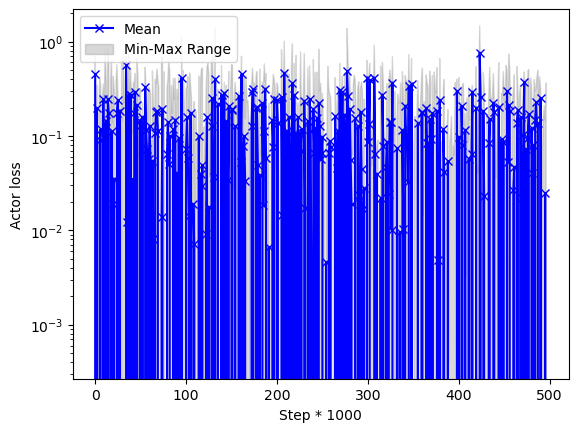

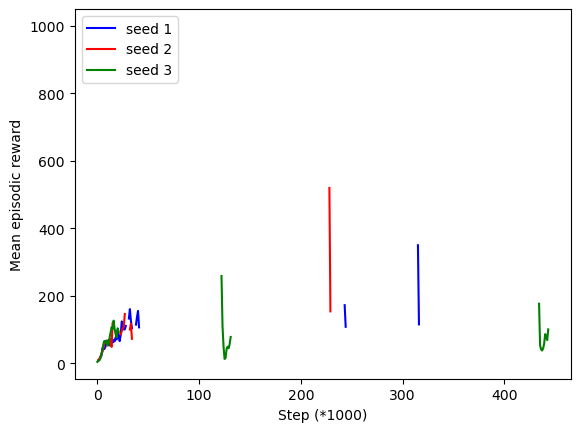

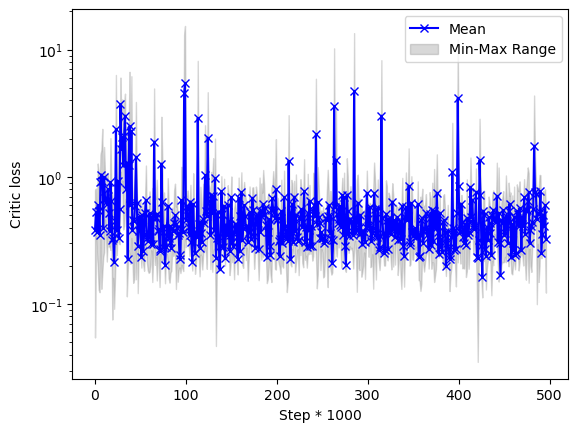

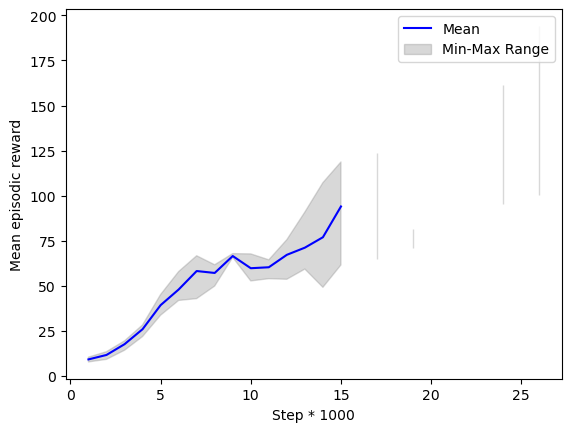

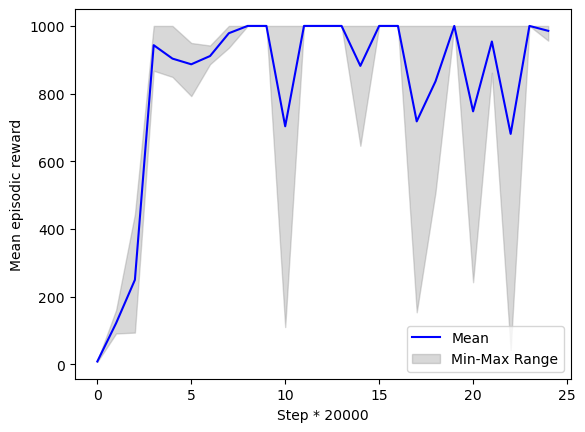

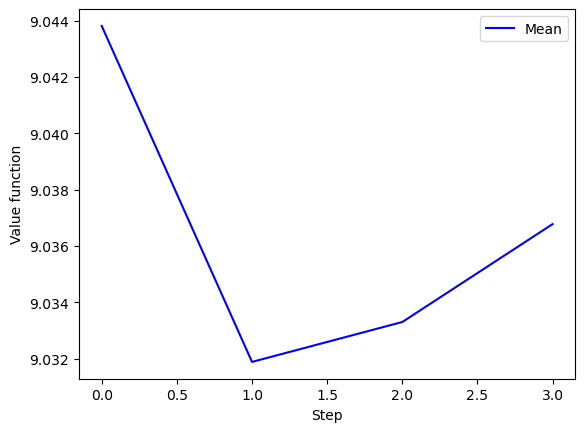

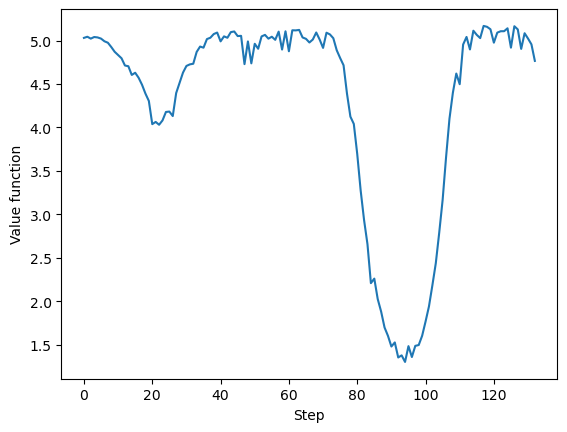

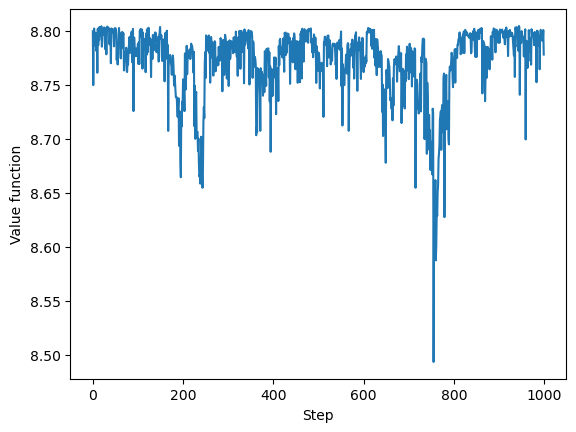

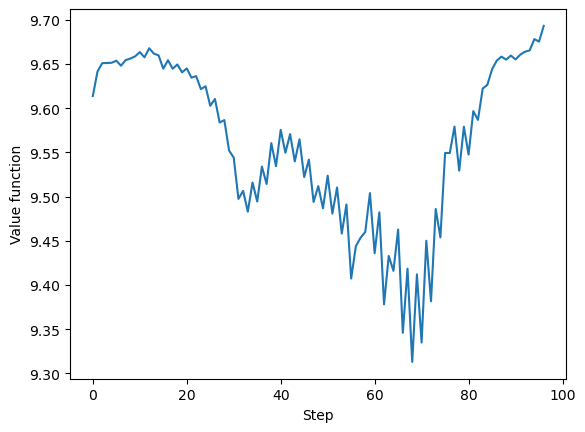

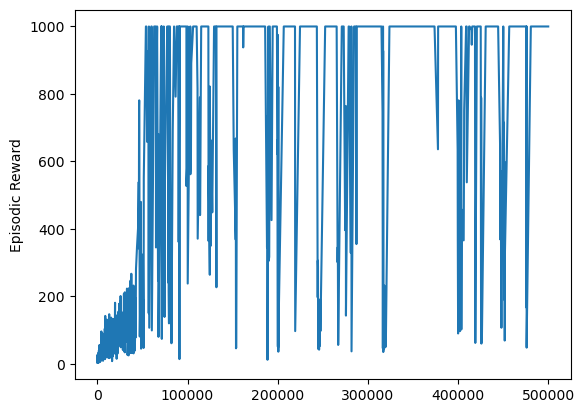

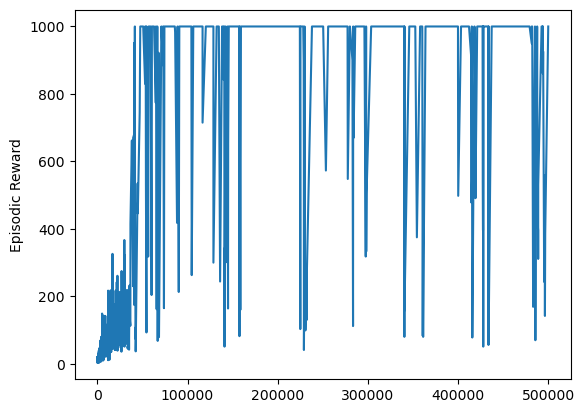

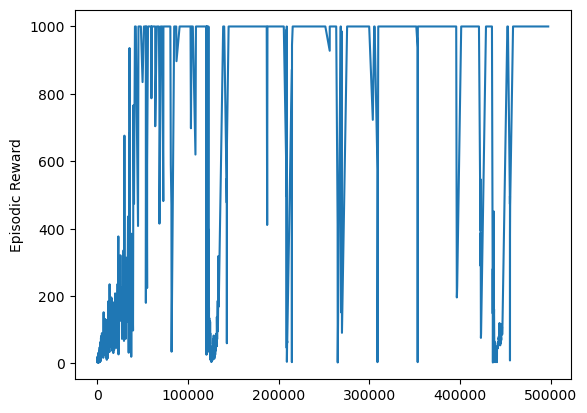

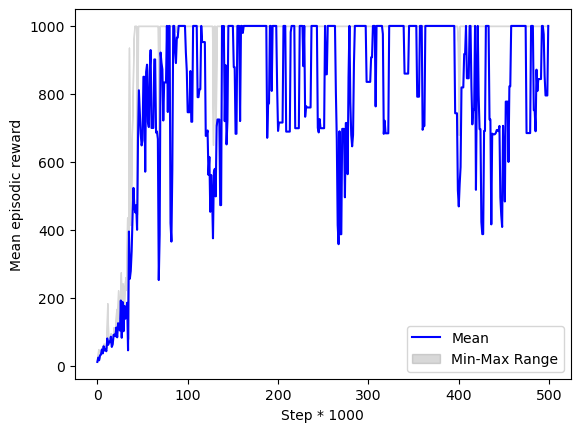

In [14]:
folder_name = 'Results_6env_6nstep_cont'
plotting(folder_name, seeds)

In [51]:
multiples_of_1000 = list(range(1000, 501000, 1000))
result = []
data = pd.read_csv(os.path.join(folder_name, str(21)+'_1_Ep_Rewards.csv'))
aggregated = data.groupby('Step', as_index=False).mean()

In [52]:
aggregated

,Step,Episodic reward
0,0,4.500000
1,36,5.600000
2,72,8.666667
3,108,6.800000
4,144,8.500000
...,...,...
911,495000,438.000000
912,498024,1000.000000
913,498060,1000.000000
914,498636,1000.000000


In [53]:
for mult in multiples_of_1000:
    filtered_df = data[data['Step'] < mult]
    if not filtered_df.empty:
        last_value = filtered_df.iloc[-1]['Episodic reward']
        result.append({'step': mult, 'value': last_value})
result_df = pd.DataFrame(result)

In [54]:
result_df

,step,value
0,1000,5.0
1,2000,14.0
2,3000,18.0
3,4000,22.0
4,5000,44.0
...,...,...
495,496000,438.0
496,497000,438.0
497,498000,438.0
498,499000,1000.0
